In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [31]:
def parse_minutes(x):
    
    spl = x.split('.')[0].split(' ')
    hours = int(spl[0]) * 60
    mins = int(spl[2]) if spl[2] != '' else 0
    return hours + mins

def read_map(P1, P2, induction_lvl=6, ctrl_replicate=2):
    
    plate_map_builder = [[P1] * 6 + [P2] * 6 for _ in range(6)]
    plate_map_builder.append([None] * 12)
    plate_map_builder.append([None, None, 'BK', 'BK', '3K3-N', '3K3-N', 'BA', 'BA', '4A3-N', '4A3-N', '4A3-P', '4A3-P'])
    plate_map = pd.concat([pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']),
               pd.DataFrame(np.array(plate_map_builder))], axis=1)
    plate_map.columns = ['group', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['group'].apply(lambda x: str(ord(x)- 65))) + ((plate_map['variable'] - 1) % induction_lvl).astype(str)
    plate_map.loc[plate_map['group'].isin(['G', 'H']), 'suffix'] = (plate_map['variable'] - 1) % ctrl_replicate
    return plate_map[['Well', 'value', 'suffix']].dropna()

def generate_metadata(well, plate_map):
    
    dictionary = pd.read_csv('datasets/dictionary.csv')
    sample_map = pd.Series(dictionary['short_name'].values, index=dictionary['id']).to_dict()
    sample_map.update({
        'BK': 'blank-kan',
        'BA': 'blank-amp',
        '3K3-N': 'negative-control-kan',
        '4A3-N': 'negative-control-amp',
        '4A3-P': 'positive-control-amp'
    })
    #sample_map.update(control_map)
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(str)
    return df.dropna()

def transpose_data(df, col):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index()
    df['time'] = df['index'].apply(parse_minutes)
    df = df.set_index('time').drop('index', axis=1)
    return df

def generate_data(df, name, h=24, m=0, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(h * 3 + idxs[i-1] + 1 + int(m/20))
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    data = blank_corr_fluo / blank_corr_od
    neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)

#### 001-002

In [22]:
folder = '033-all-and-gates-characterization'
P1, P2 = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder)).iloc[0].tolist()
plate_map = read_map(P1, P2)
raw_data = pd.read_csv('datasets/experiment/{}/001-002.csv'.format(folder), skiprows=[0])
metadata = generate_metadata(raw_data['Well'], plate_map)
data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
datas = generate_data(data, metadata['short_name'], h=24, m=0, num_data=8)

In [35]:
fluo = datas[5][filter(lambda x: '-amp' not in x, datas[5].columns)]
od = datas[4][filter(lambda x: '-amp' not in x, datas[4].columns)]
plate1 = get_neg_ctrl_corrected(fluo, od)
plate1

short_name,e11x32NrdA2_00,e11x32NrdA2_01,e11x32NrdA2_02,e11x32NrdA2_03,e11x32NrdA2_04,e11x32NrdA2_05,e15x32gp411_00,e15x32gp411_01,e15x32gp411_02,e15x32gp411_03,e15x32gp411_04,e15x32gp411_05,e11x32NrdA2_10,e11x32NrdA2_11,e11x32NrdA2_12,e11x32NrdA2_13,e11x32NrdA2_14,e11x32NrdA2_15,e15x32gp411_10,e15x32gp411_11,e15x32gp411_12,e15x32gp411_13,e15x32gp411_14,e15x32gp411_15,e11x32NrdA2_20,e11x32NrdA2_21,e11x32NrdA2_22,e11x32NrdA2_23,e11x32NrdA2_24,e11x32NrdA2_25,e15x32gp411_20,e15x32gp411_21,e15x32gp411_22,e15x32gp411_23,e15x32gp411_24,e15x32gp411_25,e11x32NrdA2_30,e11x32NrdA2_31,e11x32NrdA2_32,e11x32NrdA2_33,e11x32NrdA2_34,e11x32NrdA2_35,e15x32gp411_30,e15x32gp411_31,e15x32gp411_32,e15x32gp411_33,e15x32gp411_34,e15x32gp411_35,e11x32NrdA2_40,e11x32NrdA2_41,e11x32NrdA2_42,e11x32NrdA2_43,e11x32NrdA2_44,e11x32NrdA2_45,e15x32gp411_40,e15x32gp411_41,e15x32gp411_42,e15x32gp411_43,e15x32gp411_44,e15x32gp411_45,e11x32NrdA2_50,e11x32NrdA2_51,e11x32NrdA2_52,e11x32NrdA2_53,e11x32NrdA2_54,e11x32NrdA2_55,e15x32gp411_50,e15x32gp411_51,e15x32gp411_52,e15x32gp411_53,e15x32gp411_54,e15x32gp411_55
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-11239.153627,-40401.315789,-85285.931174,-40642.056530,-21667.273236,-71526.315789,-172187.030075,-94984.649123,-11732.484621,-56690.789474,-29901.315789,-60724.845201,-221101.315789,-77593.623482,-989901.315789,-8456.871345,-57401.315789,-91978.238866,-13387.426901,-inf,-346234.649123,-274151.315789,-126901.315789,-51006.578947,-286651.315789,-15201.315789,-13694.966583,1.138099e+06,-400567.982456,-165901.315789,-1.104901e+06,-179567.982456,-1.172901e+06,-inf,-1.036901e+06,-186901.315789,506598.684211,-515901.315789,-258151.315789,-3451.651360,-228701.315789,-67136.609907,-224701.315789,-262401.315789,-96810.406699,-116567.982456,-60713.815789,-203301.315789,1.154099e+06,-17151.315789,1.133099e+06,-inf,1.280099e+06,-1.233901e+06,-191401.315789,-390901.315789,-52851.315789,-257151.315789,-1.062901e+06,-149901.315789,-70701.315789,-35067.982456,-38862.854251,-53139.411028,-68018.962848,-80367.982456,-15266.395155,-inf,-inf,1.081099e+06,-44583.133971,-149044.172932
20,-74107.142857,-109607.142857,-197440.476190,-156607.142857,-178821.428571,-314607.142857,-93035.714286,-108198.051948,-87892.857143,-167250.000000,-94273.809524,-95607.142857,-109652.597403,-112507.142857,-141232.142857,-98690.476190,-148482.142857,-213273.809524,-29389.751553,-1.104708e+05,-168678.571429,-131551.587302,-106288.961039,-94023.809524,-107925.324675,-91491.758242,-126329.365079,-2.896071e+05,-246507.142857,-250307.142857,-8.689286e+04,-81464.285714,-1.068344e+05,-1.651071e+05,-1.572500e+05,-98273.809524,-100379.870130,-135107.142857,-156107.142857,-69518.907563,-151232.142857,-202273.809524,-86250.000000,-104288.961039,-107470.779221,-81892.857143,-61273.809524,-91690.476190,-1.716786e+05,-109561.688312,-1.463571e+05,-1.742500e+05,-2.119405e+05,-2.521071e+05,-96645.604396,-85250.000000,-199440.476190,-90184.065934,-1.907738e+05,-187773.809524,-224907.142857,-205607.142857,-129773.809524,-198107.142857,-249307.142857,-244507.142857,-150607.142857,-1.211071e+05,-1.284405e+05,-1.312183e+05,-124329.365079,-81321.428571
40,-48371.258199,-74552.136752,-146374.358974,-158107.692308,-160374.358974,-268107.692308,-62089.674290,-80406.542882,-74344.251447,-155707.692308,-85201.025641,-91962.764771,-71311.993383,-85281.025641,-163133.333333,-72086.186931,-152241.025641,-276329.914530,-22843.087497,-1.049648e+05,-167133.333333,-131676.319759,-105250.549451,-72329.914530,-73992.749779,-80403.988604,-149707.692308,-2.085319e+05,-266107.692308,-192364.102564,-7.344103e+04,-75165.163572,-1.050932e+05,-1.725179e+05,-1.449077e+05,-83218.803419,-87093.199554,-90484.503902,-142507.692308,-52709.318324,-138146.907994,-216713.752914,-72989.412738,-119967.341430,-99093.199554,-72544.473917,-56698.168498,-72552.136752,-1.200726e+05,-120704.183536,-1.304998e+05,-1.823641e+05,-2.836632e+05,-2.288956e+05,-85070.655271,-85663.2478

In [36]:
fluo = plate1.iloc[18][filter(lambda x: x.startswith('e11x32NrdA2'), plate1.iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_t

,gate,360,cuma,ara
0,e11x32NrdA2_00,-961.394814,0,0
1,e11x32NrdA2_01,-1115.770638,0,1
2,e11x32NrdA2_02,-1357.268570,0,2
3,e11x32NrdA2_03,-1428.973047,0,3
4,e11x32NrdA2_04,-1537.702129,0,4
5,e11x32NrdA2_05,-1722.212264,0,5
6,e11x32NrdA2_10,-717.298113,1,0
7,e11x32NrdA2_11,3662.951221,1,1
8,e11x32NrdA2_12,4163.654949,1,2
9,e11x32NrdA2_13,4037.040988,1,3


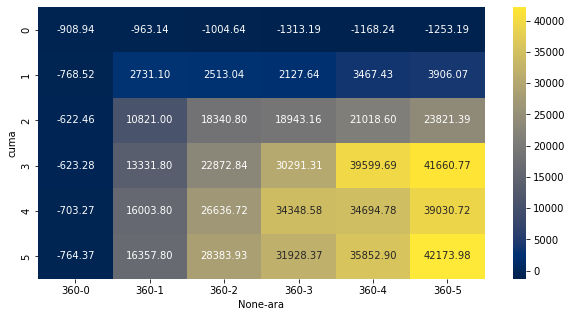

In [39]:
plt.figure(figsize=[10, 5])
fluo = plate1.iloc[18][filter(lambda x: x.startswith('e15x32gp411'), plate1.iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')
plt.show()
#fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
#sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')

<AxesSubplot:xlabel='None-ara', ylabel='cuma'>

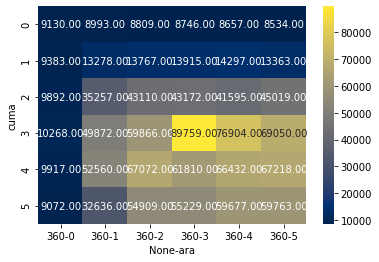

In [6]:
fluo = datas[5].iloc[18][filter(lambda x: x.startswith('e11x32NrdA2'), datas[5].iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')


<AxesSubplot:xlabel='None-ara', ylabel='cuma'>

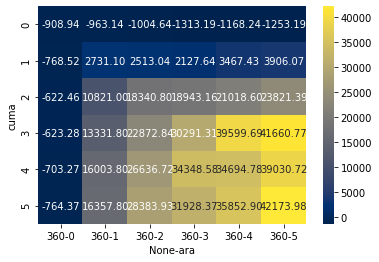

In [9]:
fluo = df.iloc[18][filter(lambda x: x.startswith('e15x32gp411'), df.iloc[18].index)]
fluo_t = fluo.reset_index().rename(columns={'short_name': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
sns.heatmap(fluo_pvt, annot=True, fmt='.2f', cmap='cividis')

In [ ]:
datas[0].to_csv('datasets/experiment/{}/ods.csv'.format(folder))
datas[1].to_csv('datasets/experiment/{}/fluos.csv'.format(folder))
datas[2].to_csv('datasets/experiment/{}/fluos-lower-1.csv'.format(folder))
datas[3].to_csv('datasets/experiment/{}/fluos-lower-2.csv'.format(folder))
datas[4].to_csv('datasets/experiment/{}/raw-ods.csv'.format(folder))
datas[5].to_csv('datasets/experiment/{}/raw-fluos.csv'.format(folder))
datas[6].to_csv('datasets/experiment/{}/raw-fluos-lower-1.csv'.format(folder))
datas[7].to_csv('datasets/experiment/{}/raw-fluos-lower-2.csv'.format(folder))